# Install Dependencies

In [1]:
!pip install torch_summary

# Import Libraries

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 

from sklearn.metrics import classification_report, recall_score
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2
from glob import glob
import pandas as pd

C:\Users\User\anaconda3\envs\lycoreco\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [4]:
DIR = '../input/140k-real-and-fake-faces/'
train_df = pd.read_csv(f'{DIR}train.csv', index_col=0)
valid_df = pd.read_csv(f'{DIR}valid.csv', index_col=0)
train_df.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


In [5]:
def label_split(df, size, fake_size, random_state=4012):
    real_size = 1 - fake_size
    real_size = int(real_size * size)
    fake_size = int(fake_size * size)
    fake_df = df[df['label'] == 0]
    real_df = df[df['label'] == 1]
    sub_fake_df = fake_df.sample(fake_size, random_state=random_state)
    sub_real_df = real_df.sample(real_size, random_state=random_state)
    new_df = pd.concat([sub_fake_df, sub_real_df])
    new_df = new_df.sample(frac=1, random_state=random_state)
    return new_df.reset_index(drop=True)

In [6]:
train_df = label_split(train_df, 10000, 0.05)
valid_df = label_split(valid_df, 2500, 0.05)

<BarContainer object of 2 artists>

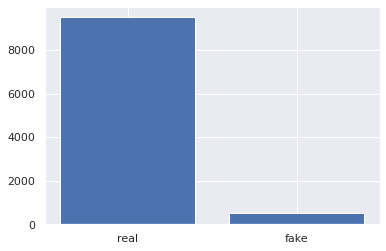

In [7]:
train_label = train_df['label_str'].value_counts()
plt.bar(train_label.index, train_label.values)

In [8]:
class FaceDataset(Dataset):
    def __init__(self, df, DIR="../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"):
        super().__init__()
        self.df = df
        self.DIR = DIR
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), 
                        (0.229, 0.224, 0.225))
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ind):
        row = self.df.iloc[ind]
        img_path = self.DIR + row['path']
        img = Image.open(img_path).convert('RGB')
        target = row['label']
        return img, target
    
    def get_real_img(self):
        real_img_ind = self.df[self.df['label'] == 1].index
        target_ind = choice(real_img_ind)
        return self[target_ind]
    
    def get_fake_img(self):
        real_img_ind = self.df[self.df['label'] == 0].index
        target_ind = choice(real_img_ind)
        return self[target_ind]
    
    def choose(self):
        return self[randint(0, len(self)-1)]
    
    def decode(self, target):
        return ['fake', 'real'][target]
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        )
        return imgs.to(device), targets.to(device)

In [9]:
train_ds = FaceDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,
                      collate_fn=train_ds.collate_fn, 
                      drop_last=True)
valid_ds = FaceDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=64,
                      collate_fn=valid_ds.collate_fn)

In [10]:
print('Size of Train:', len(train_ds))
print('Size of Validation:', len(valid_ds))

Size of Train: 10000
Size of Validation: 2500


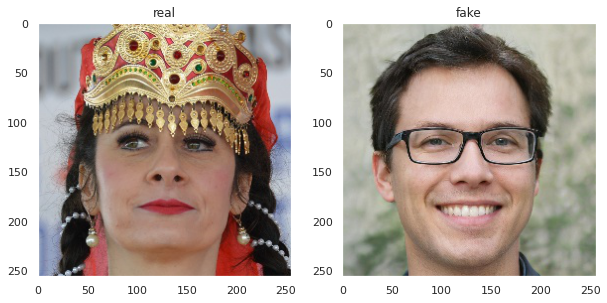

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))

# real
img, target = train_ds.get_real_img()
label = train_ds.decode(target)
ax[0].imshow(img)
ax[0].title.set_text(label)
ax[0].grid(False)

# fake
img, target = train_ds.get_fake_img()
label = train_ds.decode(target)
ax[1].imshow(img)
ax[1].title.set_text(label)
ax[1].grid(False)

plt.show()

# Model

In [2]:
class FaceClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet34(pretrained=pretrained, progress=pretrained)
        for param in self.model.parameters():
            param.requires_grad = True
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.2),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [3]:
classifier = FaceClassifier(pretrained=False)
_ = summary(classifier, torch.ones(1,3,224,224))

C:\Users\User\anaconda3\envs\lycoreco\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\lycoreco\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-3              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-5              [-1, 128, 28, 28]         295,424
|    |    └─BasicBlock: 3-6              [-1, 128, 28, 28] 

# Train

In [14]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return loss.cpu().detach().item(), fake_recall

In [15]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return loss.cpu().detach().item(), fake_recall

In [16]:
n_epochs = 15
xticks = list(i+1 for i in range(n_epochs))

## BCE Loss

In [17]:
classifier = FaceClassifier().to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2,
                                      gamma=0.95)
best_recall = 0

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [18]:
mem = {
    'train_loss': [],
    'train_recall': [],
    'valid_loss': [],
    'valid_recall': []
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recalls = [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall = train(data, classifier,
                                         optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recalls.append(train_recall)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall:', "%.3f" % train_recall, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall'].append(np.mean(train_recalls))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recalls = [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recalls.append(valid_recall)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall:', "%.3f" % valid_recall, 
            end='\r'
        )
    
    cur_recall = np.mean(valid_recalls)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall'].append(cur_recall)
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall:', "%.3f" % mem['train_recall'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall:', "%.3f" % mem['valid_recall'][-1],
    )
    
    if best_recall < cur_recall:
        best_recall = cur_recall
        torch.save(classifier.state_dict(), './saved_model/finetuned_pretrained_resnet_bce_weights.pth')
        
    scheduler.step()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.663 	train recall: 0.805 	valid loss: 0.384 	valid recall: 0.405
epoch: 2 	train loss: 0.488 	train recall: 0.688 	valid loss: 0.288 	valid recall: 0.300
epoch: 3 	train loss: 0.360 	train recall: 0.770 	valid loss: 0.262 	valid recall: 0.448
epoch: 4 	train loss: 0.326 	train recall: 0.711 	valid loss: 0.202 	valid recall: 0.544
epoch: 5 	train loss: 0.337 	train recall: 0.673 	valid loss: 0.223 	valid recall: 0.432
epoch: 6 	train loss: 0.208 	train recall: 0.771 	valid loss: 0.166 	valid recall: 0.740
epoch: 7 	train loss: 0.107 	train recall: 0.840 	valid loss: 0.085 	valid recall: 0.649
epoch: 8 	train loss: 0.084 	train recall: 0.888 	valid loss: 0.099 	valid recall: 0.724
epoch: 9 	train loss: 0.065 	train recall: 0.861 	valid loss: 0.111 	valid recall: 0.281
epoch: 10 	train loss: 0.081 	train recall: 0.897 	valid loss: 0.104 	valid recall: 0.431
epoch: 11 	train loss: 0.049 	train recall: 0.876 	valid loss: 0.051 	valid recall: 0.681
epoch: 12 	train lo

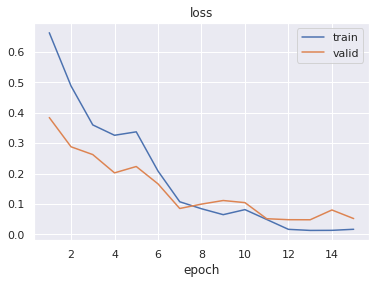

In [19]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

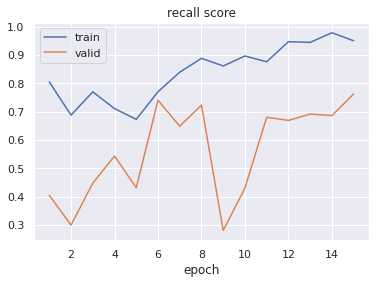

In [20]:
plt.plot(xticks, mem['train_recall'])
plt.plot(xticks, mem['valid_recall'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()

## Focal Loss

In [21]:
def focal_loss(alpha=0.25, gamma=2, reduce='mean'):
    def helper(preds, targets):
        bce_loss = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')
        pt = preds * targets + (1 - preds) * (1 - targets)
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        F_loss = alpha_t * ((1-pt)**gamma) * bce_loss
        if reduce == 'mean':
            return F_loss.mean()
        elif reduce == 'sum':
            return F_loss.sum()
    return helper

In [22]:
classifier = FaceClassifier().to(device)
loss_fn = focal_loss(alpha=0.05)
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2,
                                      gamma=0.95)
best_recall = 0

In [23]:
mem = {
    'train_loss': [],
    'train_recall': [],
    'valid_loss': [],
    'valid_recall': []
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recalls = [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall = train(data, classifier,
                                         optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recalls.append(train_recall)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall:', "%.3f" % train_recall, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall'].append(np.mean(train_recalls))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recalls = [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recalls.append(valid_recall)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall:', "%.3f" % valid_recall, 
            end='\r'
        )
    
    cur_recall = np.mean(valid_recalls)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall'].append(cur_recall)
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall:', "%.3f" % mem['train_recall'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall:', "%.3f" % mem['valid_recall'][-1],
    )
    
    if best_recall < cur_recall:
        best_recall = cur_recall
        torch.save(classifier.state_dict(), './saved_model/finetuned_pretrained_resnet_fl_weights.pth')
        
    scheduler.step()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.012 	train recall: 0.843 	valid loss: 0.007 	valid recall: 0.839
epoch: 2 	train loss: 0.006 	train recall: 0.948 	valid loss: 0.007 	valid recall: 0.924
epoch: 3 	train loss: 0.004 	train recall: 0.969 	valid loss: 0.007 	valid recall: 0.894
epoch: 4 	train loss: 0.004 	train recall: 0.915 	valid loss: 0.007 	valid recall: 0.807
epoch: 5 	train loss: 0.003 	train recall: 0.963 	valid loss: 0.005 	valid recall: 0.949
epoch: 6 	train loss: 0.003 	train recall: 0.942 	valid loss: 0.007 	valid recall: 0.777
epoch: 7 	train loss: 0.003 	train recall: 0.932 	valid loss: 0.005 	valid recall: 0.828
epoch: 8 	train loss: 0.002 	train recall: 0.930 	valid loss: 0.008 	valid recall: 0.741
epoch: 9 	train loss: 0.002 	train recall: 0.963 	valid loss: 0.005 	valid recall: 0.829
epoch: 10 	train loss: 0.002 	train recall: 0.956 	valid loss: 0.005 	valid recall: 0.854
epoch: 11 	train loss: 0.001 	train recall: 0.972 	valid loss: 0.005 	valid recall: 0.832
epoch: 12 	train lo

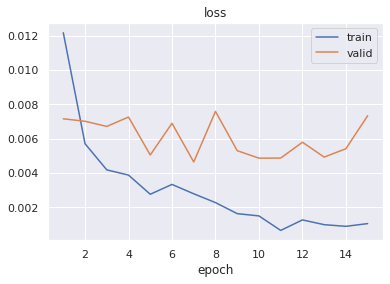

In [24]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

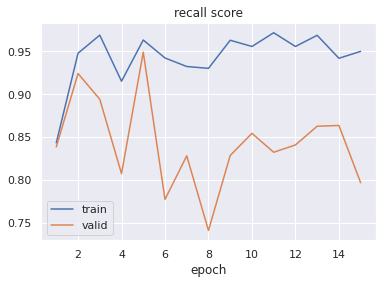

In [25]:
plt.plot(xticks, mem['train_recall'])
plt.plot(xticks, mem['valid_recall'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()